In [1]:
# !pip install --upgrade scikit-learn==0.21

In [1]:
%autosave 0
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import read_csv
import pandas
import matplotlib.pyplot as plt
import csv
from alys import save as SV
from alys import regression as alysCL

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor as dtr
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

from sklearn.preprocessing import LabelEncoder

from sklearn import utils
import sklearn.metrics as SM

import xgboost
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

# ignore Warning
import warnings
warnings.filterwarnings("ignore") 

Autosave disabled
The scikit-learn version is 0.21.0.


# Préparation des données pour le split

In [3]:
df_new = read_csv("Base_Files/moviesV.csv")
df_prod = read_csv("Base_Files/inc_movies.csv")

In [13]:
for i in df_new :
    print(i)

title
synopsis
rating
genre
prod_budget
duration
release_date
director
people
produceur
target


In [14]:
y_trainfull = np.log(df_new['target']
x_trainfull = df_new.drop(['target'], axis=1)
x_test = df_prod.drop(['imdb_id','marketing_budget'], axis=1)

In [15]:
y_trainfull.shape,x_trainfull.shape,x_test.shape

((5081,), (5081, 10), (17, 10))

In [16]:
seed = 57
np.random.seed(seed)

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x_trainfull,y_trainfull , test_size=0.3, random_state=seed)

# Preprocessing des données

In [18]:
cols = ("title","synopsis","rating","genre","director","people",'release_date',"produceur",'country',"writer")

# transformation des colonnes en categorie INT/FLOAT
for i in cols:
    lbl = LabelEncoder() 
    
    lbl.fit(list(x_train[i].values)) 
    x_train[i] = lbl.fit_transform(list(x_train[i].values))
    
    lbl.fit(list(x_val[i].values)) 
    x_val[i] = lbl.fit_transform(list(x_val[i].values))
    
    lbl.fit(list(x_test[i].values)) 
    x_test[i] = lbl.fit_transform(list(x_test[i].values))
        
print(utils.multiclass.type_of_target(x_train))
print(utils.multiclass.type_of_target(y_train))

multiclass-multioutput
continuous


In [19]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape 

((3556, 10), (1525, 10), (3556,), (1525,))

# Creation de model pour le voting regressor

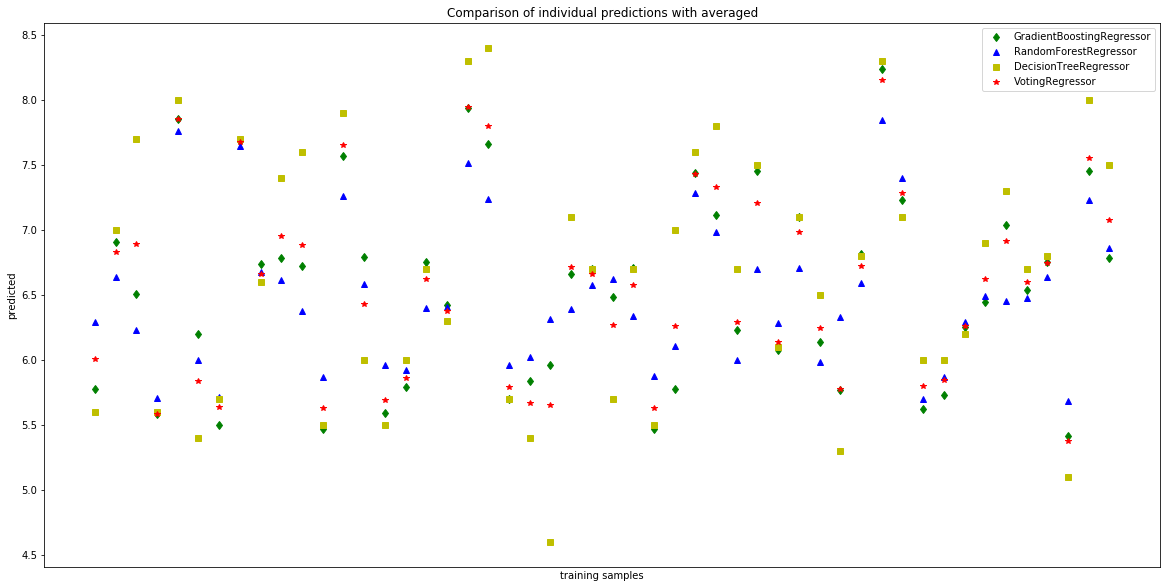

VotingRegressor(estimators=[('gb',
                             GradientBoostingRegressor(alpha=0.9,
                                                       criterion='mae',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=5,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_est

In [11]:
def model_voting():
    
    reg1 = GradientBoostingRegressor(criterion='mae', n_estimators=200, max_depth=5)
    
    reg2 = RandomForestRegressor(criterion='mae', n_estimators=200, max_depth=5)
    
    reg3 = dtr(criterion='mae', splitter='best',max_depth=None, min_samples_split=2,
              min_samples_leaf=1, min_weight_fraction_leaf=0.0,
              max_features=None, random_state=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None)

    xgb = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
    
    reg1 = reg1.fit(x_train, y_train)
    reg2 = reg2.fit(x_train, y_train)
    reg3 = reg3.fit(x_train, y_train)
    xgb = xgb.fit(x_train,y_train)

    xt = x_train[:50]

    plt.figure(figsize=(20,10))
    plt.plot(reg1.predict(xt), 'gd', label='GradientBoostingRegressor')
    plt.plot(reg2.predict(xt), 'b^', label='RandomForestRegressor')
    plt.plot(reg3.predict(xt), 'ys', label='DecisionTreeRegressor')
    plt.plot(xgb.predict(xt), 'r*', label='VotingRegressor')
    plt.tick_params(axis='x', which='both', bottom=False, top=False,
                    labelbottom=False)
    plt.ylabel('predicted')
    plt.xlabel('training samples')
    plt.legend(loc="best")
    plt.title('Comparison of individual predictions with averaged')
    plt.show()
    
    return xgb, reg3

xgb, reg3 = model_voting()
xgb

# Test sur fichier de validation avec VotingRegressor et DecisionTreeRegressor

In [12]:
def train():
    print("Model Voting")
    
    vote_pred = xgb.predict(x_val)
    RMSE = np.sqrt(MSE(vote_pred, y_val))
    score = SM.mean_absolute_error(vote_pred,y_val)
    
    print("RMSE = ",RMSE.round(4))
    print("MAPE = ", score)

    print("Model DecisionTreeRegressor")
    
    reg3_pred = reg3.predict(x_val)

    RMSE = np.sqrt(MSE(reg3_pred, y_val))
    score = SM.mean_absolute_error(reg3_pred,y_val)
    
    print("RMSE = ",RMSE.round(4))
    print("MAPE = ", score)
    return vote_pred, reg3_pred

vote_pred, reg3_pred = train()

Model Voting
RMSE =  0.9312
MAPE =  0.7112713241129595
Model DecisionTreeRegressor
RMSE =  1.3225
MAPE =  1.0254426229508196


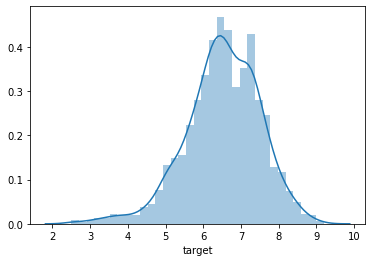

In [13]:
y_val
sns.distplot(y_val)

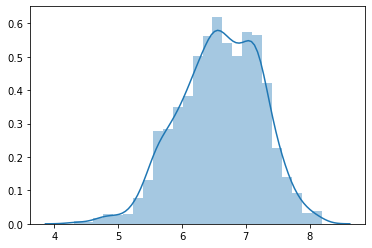

In [14]:
vote_pred
sns.distplot(vote_pred)

In [15]:
vote_pred

array([7.56947862, 7.34850331, 5.55595534, ..., 6.18234757, 7.10681606,
       6.16723667])

(array([561., 443., 263., 126.,  74.,  29.,  11.,  11.,   4.,   3.]),
 array([7.36603821e-04, 4.00936441e-01, 8.01136279e-01, 1.20133612e+00,
        1.60153595e+00, 2.00173579e+00, 2.40193563e+00, 2.80213547e+00,
        3.20233531e+00, 3.60253514e+00, 4.00273498e+00]),
 <a list of 10 Patch objects>)

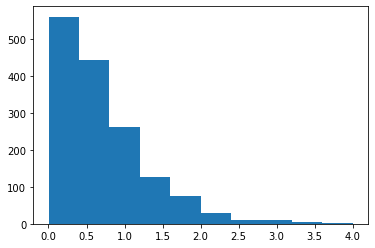

In [16]:

err_hist = np.abs(y_val - vote_pred)
plt.hist(err_hist)

# Fichier de test décembre 2019

In [17]:
prod_pred_vote = xgb.predict(x_test)
prod_pred_vote

array([7.00947224, 7.20233785, 7.87962994, 7.30183155, 6.61464034,
       7.79521893, 6.80525648, 7.46753731, 6.93478896, 7.02693976,
       6.68569546, 7.19783613, 7.37615036, 7.0638708 , 7.93306838,
       7.31106854, 7.9627774 ])

In [18]:
prod_pred_decisonTree = reg3.predict(x_test)
prod_pred_decisonTree

array([6.8, 6.8, 8.5, 6.8, 6.8, 8.5, 6.8, 8.6, 6.8, 6.8, 6.8, 8.6, 8.6,
       6.8, 8.4, 7. , 8.4])

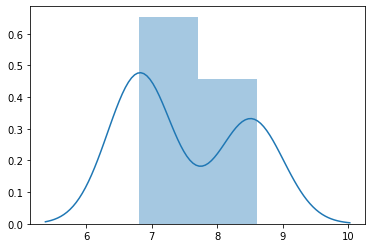

In [19]:
prod_pred_decisonTree
sns.distplot(prod_pred_decisonTree)

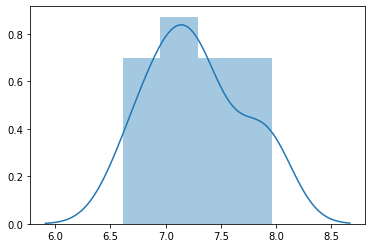

In [20]:
prod_pred_vote
sns.distplot(prod_pred_vote)

# Xgboost

In [33]:
param_grid = [{'n_estimators': [300,400,500,600],'max_depth': [4,5,6,7],
               'colsample_bytree' : [0.3,0.4,0.5,0.6],'subsample' : [0.6,0.7,0.8,0.9]
               
#               'learning_rate':[0.04,0.05,0.06],'min_child_weight': [1.6,1.7,1.8],
#                'reg_alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],'reg_lambda': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#                'gamma': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09],'silent': [1,2,3,4,5,6,7,8,9],
#                'random_state': [1,2,3,4,5,6,7,8,9], 'nthread' : [-2,-1.5,-1.25,-1,-0.75,-0.5,-0.25]
              }]
my_learn = xgboost.XGBRegressor()
grid_search = GridSearchCV(my_learn,param_grid, cv=5, scoring ='neg_mean_squared_error', return_train_score=True)
grid_search.fit(x_train,y_train)

[10:46:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[10:47:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:47:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:47:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:47:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:47:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:47:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[10:48:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[10:49:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:49:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:49:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:49:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:49:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:49:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[10:51:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:51:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:51:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:51:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:51:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:51:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[10:52:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:52:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:52:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:52:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:52:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:53:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[10:54:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:54:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:54:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:54:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:54:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:54:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[10:57:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:57:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:57:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:57:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:57:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:57:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[10:58:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:58:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:58:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:58:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:58:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:58:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[10:59:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:00:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:00:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:00:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:00:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:00:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:00:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:02:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:02:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:02:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:02:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:02:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:02:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:04:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:06:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:06:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:06:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:06:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:06:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:06:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:08:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:08:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:08:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:09:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:10:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:10:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:11:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:11:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:11:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:11:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:11:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:11:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:12:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:12:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:12:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:12:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:14:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:16:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:16:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:16:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:16:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:16:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:16:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:18:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:18:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:18:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:18:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:18:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:18:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:21:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:21:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:21:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:21:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:21:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:21:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:23:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:24:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:25:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:25:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:25:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:25:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:25:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:26:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:27:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:29:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:32:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:32:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:32:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:32:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:32:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:32:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[11:34:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid=[{'colsample_bytree': [0.5, 0.6, 0.7, 0.8],
                          'max_depth': [2, 3, 4, 5],
 

In [34]:
grid_search.best_params_

{'colsample_bytree': 0.5,
 'max_depth': 5,
 'n_estimators': 400,
 'subsample': 0.8}

In [20]:
regressor = XGBRegressor(colsample_bytree= 0.5, gamma= 0.7, max_depth= 5,n_estimators= 400, min_child_weight= 5,
                         subsample = 0.8, objective='reg:squarederror')
mod = regressor.fit(x_train, y_train)

In [21]:
pred_test_ann = mod.predict(x_val)
RMSE = np.sqrt(MSE(pred_test_ann, y_val))
score = SM.mean_absolute_error(pred_test_ann,y_val)

print("RMSE = ",RMSE.round(4))
print("MAPE = ", score)

# Model Voting
# RMSE =  0.9312
# MAPE =  0.7112713241129595

RMSE =  0.9639
MAPE =  0.7450167273224378


In [22]:
pred = mod.predict(x_test)
pred

array([6.3084183, 6.9950986, 7.144137 , 6.405001 , 6.148741 , 7.1494837,
       6.0723057, 7.305435 , 7.447752 , 6.949943 , 6.660691 , 7.4058175,
       7.578344 , 6.916934 , 7.1050463, 6.8824306, 6.7354765],
      dtype=float32)

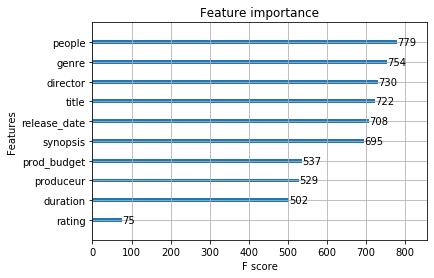

In [23]:
xgboost.plot_importance(mod)

# Comparaison avec les prédictions de bigML 

In [39]:

df_pred = read_csv('Rapport/suivi_ensemble.csv')
df_v_bigml = read_csv('Pred_Files/ml_ensemble1.csv')

def Follow() :
    # creation d'un df temporaire pour plus de lisibilité
    df_temp = pandas.DataFrame()
    col = ('imdb_id','title','target')
    
    for i in col :
        df_temp[i] = df_pred[i]
        
    df_temp['pred_bigML'] = round(df_v_bigml['pred'],2)  
    df_temp['pred_Xgboost'] = np.around(pred,decimals=2)
    
        # fonction pour une analyse des erreurs
    alysCL.regr(df_temp)
    return df_temp

board = Follow()
board

nom colonne prediction : pred_Xgboost
nom colonne output : target
MAPE =  15.76


,imdb_id,title,target,pred_bigML,pred_Xgboost,pourcerror,errorabs,mape,RMSE
0,tt6141246,The Aeronauts,6.6,6.52,6.31,-0.043939,0.04,15.76,1.109409
1,tt10080270,En Brazos de un Asesino,6.1,6.10,7.00,0.147541,0.15,NaN,NaN
2,tt8613070,Portrait de la jeune fille en feu,8.3,7.05,7.14,-0.139759,0.14,NaN,NaN
3,tt9204204,Little Joe,5.8,6.86,6.41,0.105172,0.11,NaN,NaN
4,tt6010976,Midnight Family,7.7,6.52,6.15,-0.201299,0.20,NaN,NaN
5,tt7975244,Jumanji: Next Level,7.0,7.20,7.15,0.021429,0.02,NaN,NaN
6,tt10481868,Black Christmas,3.2,5.81,6.07,0.896875,0.90,NaN,NaN
7,tt5727208,Uncut Gems,8.1,7.17,7.31,-0.097531,0.10,NaN,NaN
8,tt5827916,Une vie cachée,7.7,7.52,7.45,-0.032468,0.03,NaN,NaN
9,tt1780967,Seberg,4.7,6.29,6.95,0.478723,0.48,NaN,NaN
